In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 
%load_ext tensorboard

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
import tensorflow as tf 
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import tensorflow.keras.backend as kb
import yaml
import datetime
import glob

In [4]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [5]:
from HelperFn.ExpData_Generator import TrainingGenerator
from HelperFn.ExpData_Generator import EvalTestGenerator
from HelperFn.utils import Params
from sklearn.metrics import r2_score

In [6]:
# recommended params.json is included in run_1 folder, ready for demo run. 
# archive_final_run folder contain pre-trained model (best model)
mini_EXP_name = 'new_clay_exp'
exp_folder_path = 'experiments/' + mini_EXP_name

DATA_DIR = '../../processed_input_data_clay/'
NPY_FOLDER = 'slice_npy/'
ML_EXP = 'split_master/'
Train_Master = 'train_master.txt'
Eval_Master = 'eval_master.txt'
Test_Master = 'test_master.txt'
json_path = os.path.join(exp_folder_path, 'params.json')

In [7]:
params = Params(json_path)

input_slice_shape = (128,64,1)
batch_size = params.batch_size
MMT = params.bn_momentum
LR = params.learning_rate
num_channels = params.num_channels
EPOCH = params.num_epochs

In [8]:
## define model
model = Sequential()
model.add(layers.Input(shape=input_slice_shape))
# channels = [num_channels, num_channels * 2,num_channels * 4 ]
channels = [num_channels, num_channels * 2]
for c in channels:
    model.add(layers.Conv2D(c, 3, padding='same'))
    model.add(layers.Conv2D(c, 3, dilation_rate = 2, padding='same'))
    model.add(layers.BatchNormalization(momentum=MMT))
    model.add(layers.Activation(activation='relu'))
    model.add(layers.MaxPooling2D(2))
model.add(layers.Flatten())
model.add(layers.Dense(channels[-1]))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization(momentum=MMT))
model.add(layers.Dense(1, activation='relu'))
#summarize the model
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 64, 4)        40        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 64, 4)        148       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 64, 4)        16        
_________________________________________________________________
activation (Activation)      (None, 128, 64, 4)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 32, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 32, 8)         296       
__________________________________________________

In [9]:
def MSE_wSD_loss(Y_true, KE_pred):
    KE_true = Y_true[:, 0]
    SD_true = Y_true[:, 1]
    mse = tf.keras.losses.MeanSquaredError()
    return mse(Y_true[:, 0], KE_pred)/((Y_true[:, 1])**2+1e-5)

def custom_accuracy_2SD(Y_true, KE_pred):
    KE_true = Y_true[:, 0]
    SD_true = Y_true[:, 1]
    KE_pred = KE_pred[:, 0]
    C_accuracy = kb.mean(kb.cast(kb.less_equal(kb.abs(KE_pred-KE_true),2*SD_true), dtype = "float32"))
    return C_accuracy 

In [10]:
# compile the model
opt = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(optimizer=opt, loss = MSE_wSD_loss, 
              metrics=['mse', custom_accuracy_2SD])

In [11]:
filepath = exp_folder_path + "/weights-improvement-{epoch:02d}-{val_custom_accuracy_2SD:.2f}.hdf5"
callbacks = [
#     tf.keras.callbacks.TensorBoard(log_dir='logs'),
#     tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.000001,
#                                      patience=5,mode='min'),
    tf.keras.callbacks.ModelCheckpoint(
        filepath, monitor ='val_loss', verbose=1,
        save_best_only=True, mode= 'min')
]

In [12]:
training_generator = TrainingGenerator(ML_EXP, NPY_FOLDER, Train_Master, batch_size = batch_size, data_dir=DATA_DIR)
validation_generator = EvalTestGenerator(ML_EXP, NPY_FOLDER, Eval_Master, batch_size = batch_size, data_dir=DATA_DIR)

9479
9479
shuffling
1524
1524


In [13]:
# configure early stopping
# fit the model
history = model.fit(x=training_generator, epochs=EPOCH,
                    validation_data=validation_generator, 
                    callbacks = callbacks,
                    use_multiprocessing=False)

2022-05-26 15:16:43.429099: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/50
37/37 [==============================] - ETA: 0s - batch: 18.0000 - size: 256.0000 - loss: 156.6350 - mse: 0.4355 - custom_accuracy_2SD: 0.1832

/Users/akshay/miniforge3/envs/nn682/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 20.10271, saving model to experiments/new_clay_exp/weights-improvement-01-0.51.hdf5
37/37 [==============================] - 12s 297ms/step - batch: 18.0000 - size: 256.0000 - loss: 156.6350 - mse: 0.4355 - custom_accuracy_2SD: 0.1832 - val_loss: 20.1027 - val_mse: 0.1985 - val_custom_accuracy_2SD: 0.5055
Epoch 2/50
37/37 [==============================] - ETA: 0s - batch: 18.0000 - size: 256.0000 - loss: 77.2535 - mse: 0.2358 - custom_accuracy_2SD: 0.3148
Epoch 00002: val_loss did not improve from 20.10271
37/37 [==============================] - 10s 280ms/step - batch: 18.0000 - size: 256.0000 - loss: 77.2535 - mse: 0.2358 - custom_accuracy_2SD: 0.3148 - val_loss: 23.4372 - val_mse: 0.1901 - val_custom_accuracy_2SD: 0.4898
Epoch 3/50
37/37 [==============================] - ETA: 0s - batch: 18.0000 - size: 256.0000 - loss: 53.7523 - mse: 0.2161 - custom_accuracy_2SD: 0.4096
Epoch 00003: val_loss improved from 20.10271 to 8.88912, saving mod

In [14]:
history.__dict__

{'validation_data': None,
 'model': <keras.engine.sequential.Sequential at 0x166fea6a0>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [156.6349797635465,
   77.25346704431482,
   53.75226154842892,
   38.19635880960001,
   31.410804387685413,
   26.603589599196976,
   21.537481900807972,
   19.11517248926936,
   17.552586529705977,
   16.06225150340312,
   14.538048331801956,
   13.031808286099821,
   11.647162927163613,
   10.912369779638341,
   9.42728007806314,
   8.542404522766939,
   8.468114053880846,
   7.447850162918503,
   6.396921364036766,
   5.675151399663977,
   5.264591590778248,
   4.558217351501052,
   4.608008307379645,
   4.125425441845043,
   3.920428172962086,
   3.9747441008284286,
   3.861490230302553,
   3.9396146374779777,
   3.6458067893981934,
   3.5732602686495394,
   3.6575308619318783,
   3.5224157668448783,
   3.497761906804265,
   3.41960562242044,
   3.5071831071698987,
   3.3646294007430204,
   3.368396423958443,
   3.2

In [15]:
raw_history = history.history
with open (exp_folder_path + "/raw_history.yaml", "w") as filehandle:
    yaml.dump(history.history,filehandle)

In [16]:
with open(exp_folder_path + "/raw_history.yaml", "r") as filehandle2:
    raw_history = yaml.load(filehandle2, Loader = yaml.Loader)

In [17]:
val_loss = raw_history['val_loss']
train_accuracy = raw_history['custom_accuracy_2SD']
val_accuracy = raw_history['val_custom_accuracy_2SD']
best_model_EPOCH = val_loss.index(min(val_loss)) + 1 
selected_history = {}
selected_history['Bmodel_EPOCH'] = best_model_EPOCH
selected_history['min_val_loss'] =  np.round(min(val_loss),4)
selected_history['max_train_accuracy'] =  np.round(max(train_accuracy),4)
selected_history['max_val_accuracy'] =  np.round(max(val_accuracy),4)
selected_history['Bmodel_train_accuracy'] =  np.round(train_accuracy[val_loss.index(min(val_loss))],4)
selected_history['Bmodel_val_accuracy'] = np.round(val_accuracy[val_loss.index(min(val_loss))],4)

In [18]:
selected_history

{'Bmodel_EPOCH': 47,
 'min_val_loss': 1.4864,
 'max_train_accuracy': 0.9153,
 'max_val_accuracy': 0.9758,
 'Bmodel_train_accuracy': 0.9067,
 'Bmodel_val_accuracy': 0.9758}

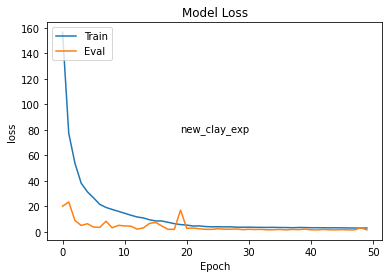

In [19]:
plt.plot(raw_history['loss'][0:EPOCH])
plt.plot(raw_history['val_loss'][0:EPOCH])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.text(0.5, 0.5, mini_EXP_name, 
         horizontalalignment = 'center', transform=plt.gca().transAxes)
plt.legend(['Train','Eval'], loc='upper left')
plt.savefig(exp_folder_path  +'/loss_.png')
plt.show()

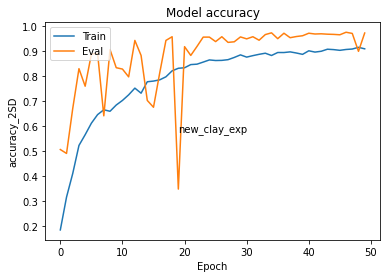

In [20]:
plt.plot(raw_history['custom_accuracy_2SD'][0:EPOCH])
plt.plot(raw_history['val_custom_accuracy_2SD'][0:EPOCH])
plt.title('Model accuracy')
plt.ylabel('accuracy_2SD')
plt.xlabel('Epoch')
plt.text(0.5, 0.5, mini_EXP_name, 
         horizontalalignment = 'center', transform=plt.gca().transAxes)
plt.legend(['Train','Eval'], loc='upper left')
plt.savefig(exp_folder_path + '/custom_accuracy_2SD.png')
plt.show()

In [21]:
files = glob.glob(exp_folder_path + '/*.hdf5',  
                   recursive = True)
saved_model = []
for file in files:
    print(file.split('/')[-1])
    saved_model.append(file.split('/')[-1])

weights-improvement-03-0.67.hdf5
weights-improvement-04-0.83.hdf5
weights-improvement-34-0.97.hdf5
weights-improvement-47-0.98.hdf5
weights-improvement-01-0.51.hdf5
weights-improvement-09-0.91.hdf5
weights-improvement-07-0.89.hdf5
weights-improvement-30-0.96.hdf5
weights-improvement-18-0.94.hdf5
weights-improvement-06-0.89.hdf5
weights-improvement-13-0.94.hdf5
weights-improvement-25-0.96.hdf5
weights-improvement-37-0.97.hdf5


In [23]:
# Every epoch that show improving performance will be saved. 
# weights-improvment-'Epoch'-'Eval_2SD_Accuracy'
# 'selectedE' must be updated as 'Epoch' in which 'Eval_2SD_Accuracy' is highest 

selectedE = '37'

for file in saved_model:
    if file.split('-')[-2][0:2]==str(selectedE):
        selected_weights = file
print (selected_weights)  

weights-improvement-37-0.97.hdf5


In [24]:
filepath = exp_folder_path + '/' + selected_weights 
print(filepath)

experiments/new_clay_exp/weights-improvement-37-0.97.hdf5


In [25]:
best_model = tf.keras.models.load_model(
    filepath, custom_objects = {"MSE_wSD_loss":MSE_wSD_loss, 
                                "custom_accuracy_2SD": custom_accuracy_2SD})
# best_model = tf.keras.models.load_model(filepath)
# best_model = tf.keras.models.load_model(filepath, custom_objects={"MSE_wSD_loss":MSE_wSD_loss})
# best_model = tf.keras.models.load_model(filepath)

In [26]:
#apply best model to three subset of data

##Training
train_generator = EvalTestGenerator(ML_EXP, NPY_FOLDER, Train_Master, 
                                       batch_size = batch_size, 
                                       data_dir=DATA_DIR, shuffle = False)
train_label = np.hstack([batch[1][:,0] for batch in train_generator])
train_SD = np.hstack([batch[1][:,1] for batch in train_generator])
train_pred = best_model.predict(x=train_generator)

##Validation
eval_generator = EvalTestGenerator(ML_EXP, NPY_FOLDER, Eval_Master, 
                                         batch_size = batch_size, 
                                         data_dir=DATA_DIR, shuffle = False)
eval_label = np.hstack([batch[1][:,0] for batch in eval_generator])
eval_SD = np.hstack([batch[1][:,1] for batch in eval_generator])
eval_pred = best_model.predict(x=eval_generator)

##Testing
test_generator = EvalTestGenerator(ML_EXP, NPY_FOLDER, Test_Master, 
                                   batch_size = batch_size, 
                                   data_dir=DATA_DIR, shuffle = False)
test_label = np.hstack([batch[1][:,0] for batch in test_generator])
test_SD = np.hstack([batch[1][:,1] for batch in test_generator])
test_pred = best_model.predict(x=test_generator)

9479
9479
1524
1524
1518
1518


In [27]:
train_LSP = [train_label,train_SD,train_pred]
eval_LSP = [eval_label,eval_SD,eval_pred]
test_LSP = [test_label,test_SD,test_pred]
generator_LSP = [train_LSP,eval_LSP,test_LSP]

In [28]:
def plotting_with_TS_V(generator_LSP, mode, selected_EP):
    ## make cross plot between prediction and label with highlighted color for subset that meet threashold
    
    fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(5,12.5))

    for g, m, ax in zip(generator_LSP, mode, axs): 
        label = g[0]
        SD = g[1]
        pred = g[2].flatten()
#         if len(pred) == len(label):
#             print(len(pred))
        idx = np.abs(pred-label) > 2*SD
        error_pct = np.round(100*np.sum(idx)/len(pred), 2)
        

        ax.plot(pred, label,'o', label=f'Correct')
        ax.plot(pred[idx], label[idx], 'ro', label=f'Incorrect')
        ax.plot([0, 1], [0, 1], 'k', alpha=0.2)
        ax.set_title(str(m), fontsize = 24)
        text_error = '% error (>2SD) = ' +str(error_pct) + '%'
        ax.text(0.7, 0.1, text_error, fontsize = 12,
                horizontalalignment = 'center', transform=ax.transAxes)
        ax.legend(loc='best')
        ax.set_ylabel('Truth', fontsize =18)
    axs[2].set_xlabel('Prediction', fontsize = 18)

    plt.tight_layout()
    plt.show

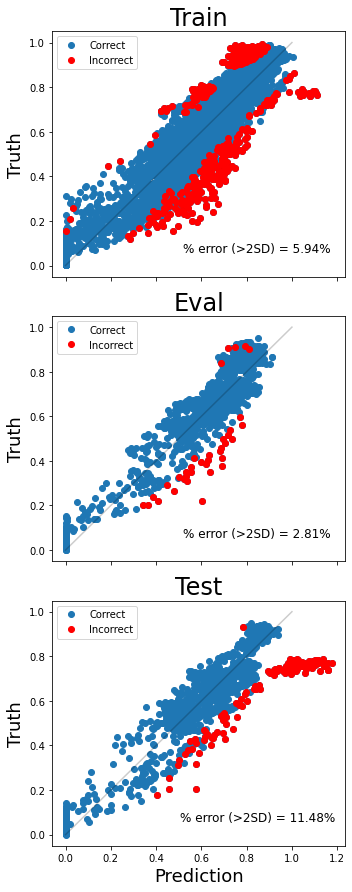

In [29]:
plotting_with_TS_V(generator_LSP, ['Train', 'Eval', 'Test'], selected_EP = selectedE)